In [1]:
import numpy as np
import struct
from array import array
from os.path  import join
%matplotlib inline
import random
import matplotlib.pyplot as plt

In [2]:
class MnistDataloader:
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        return x_train, y_train, x_test, y_test

In [3]:
#
# Set file paths based on added MNIST Datasets
#
input_path = 'mnist/'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath,
                                   training_labels_filepath,
                                   test_images_filepath,
                                   test_labels_filepath)

x_train, y_train, x_test, y_test = mnist_dataloader.load_data()

In [4]:
# normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

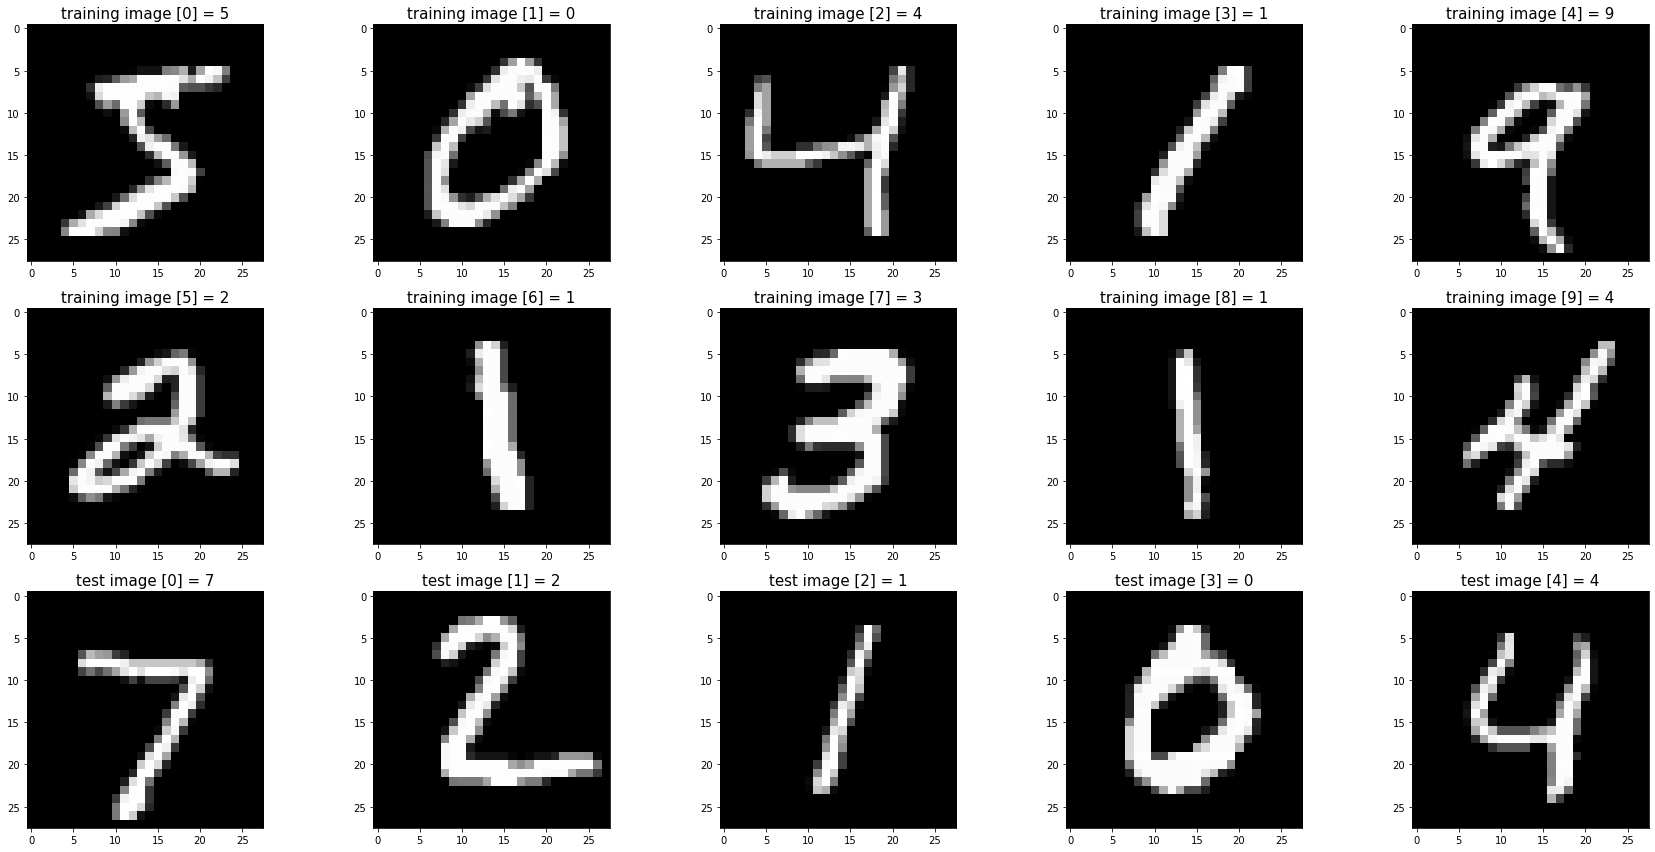

In [5]:
#
# Verify Reading Dataset via MnistDataloader class
#


def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Show train and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = i
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = i
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [6]:
def ReLU(x):
    return np.maximum(0, x)

In [7]:
def diff_ReLU(x):
    return np.array(x>=0, dtype=np.int8)

In [8]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis = 1, keepdims = True))
    return e_x / np.sum(e_x, axis = 1, keepdims = True)

In [9]:
def cross_entropy(y_pred, y_true):
    batch_size = y_pred.shape[0]
    res = np.log(1 - y_pred)
    res[range(batch_size), y_true.flatten()] = np.log(y_pred)[range(batch_size), y_true.flatten()]
    return -np.sum(res) / batch_size

In [10]:
def accuracy(y_pred, y_true):
    y_pred = np.argmax(y_pred, axis=1)
    return np.mean(y_pred == y_true)

In [11]:
class NN:
    def __init__(self, hidden_neurons_count):
        self.hidden_neurons_count = hidden_neurons_count
        self.input_neurons_count = 28 * 28
        self.output_neurons_count = 10
        
        # weight matrix from input to hidden
        self.W = np.random.randn(self.input_neurons_count, self.hidden_neurons_count) * np.sqrt(2.0/self.input_neurons_count)
        
        # bias for hidden
        self.w = np.zeros((1, self.hidden_neurons_count))
        
        # weight matrix from hidden to output
        self.V = np.random.randn(self.hidden_neurons_count, self.output_neurons_count) * np.sqrt(2.0/self.hidden_neurons_count)
        # bias for output
        self.v = np.zeros((1, self.output_neurons_count))
    
    def fit(self, x, y, lr):
        self.forward(x)
        self.backward(x, y)
        self.step(lr)
        return self.g
    
    def predict(self, x):
        self.forward(x)
        return self.g
    
    def forward(self, x):
        # forward from input to hidden
        self.s = x @ self.W + self.w
        self.z = ReLU(self.s)
        self.delta_relu = diff_ReLU(self.s)
        
        # forward from hidden to output
        self.t = self.z @ self.V + self.v
        self.g = softmax(self.t)
        
    def backward(self, x, y):
        batch_size = x.shape[0]
        
        # backward from output to hidden
        self.delta_t = np.copy(self.g)
        self.delta_t[range(batch_size), y.flatten()] -= 1
        
        self.dV = self.z.T @ self.delta_t
        self.dv = np.sum(self.delta_t, axis=0, keepdims=True)
        
        # backward from hiddent to input
        self.delta_z = self.delta_t @ self.V.T
        self.delta_s = self.delta_z * self.delta_relu
        
        self.dW = x.T @ self.delta_s 
        self.dw = np.sum(self.delta_s, axis=0, keepdims=True)

    
    def step(self, lr):
        batch_size = self.g.shape[1]
        theta = lr / batch_size
        
        self.W -= theta * self.dW
        self.w -= theta * self.dw
        self.V -= theta * self.dV
        self.v -= theta * self.dv

In [12]:
s = 300
lr = 0.1
batch_size = 8
num_epoch = 20

In [13]:
nn = NN(s)

In [14]:
def train(nn, x_train, y_train, num_epoch, batch_size, lr):
    for epoch in range(num_epoch):
        # shuffle
        idx = np.random.permutation(len(y_train))
        x_train_perm = x_train[idx]
        y_train_perm = y_train[idx]
        
        batch_loss = []
        batch_accuracy = []
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train_perm[i:i + batch_size]
            x_batch = x_batch.reshape(-1, 28 * 28)
            
            y_batch = y_train_perm[i:i + batch_size]
            y_batch = y_batch.reshape(batch_size, -1)

            output = nn.fit(x_batch, y_batch, lr)
            batch_loss.append(cross_entropy(output, y_batch.flatten()))
            batch_accuracy.append(accuracy(output, y_batch.flatten()))

        mean_per_batch_loss = np.mean(batch_loss)
        mean_per_batch_accuracy = np.mean(batch_accuracy)
        print(f'Epoch {epoch + 1}/{num_epoch}, Mean per batch loss: {mean_per_batch_loss},  Mean per batch accuracy: {mean_per_batch_accuracy}')

In [15]:
%%time
train(nn, x_train, y_train, num_epoch=num_epoch, batch_size=batch_size, lr=lr)

Epoch 1/20, Mean per batch loss: 0.34980393264203474,  Mean per batch accuracy: 0.93865
Epoch 2/20, Mean per batch loss: 0.15344380782846723,  Mean per batch accuracy: 0.97335
Epoch 3/20, Mean per batch loss: 0.10713685853247204,  Mean per batch accuracy: 0.9817166666666667
Epoch 4/20, Mean per batch loss: 0.0785672998531968,  Mean per batch accuracy: 0.9868
Epoch 5/20, Mean per batch loss: 0.05571710929185135,  Mean per batch accuracy: 0.9904666666666667
Epoch 6/20, Mean per batch loss: 0.0397458484025672,  Mean per batch accuracy: 0.9937833333333334
Epoch 7/20, Mean per batch loss: 0.02974247234166073,  Mean per batch accuracy: 0.9955666666666667
Epoch 8/20, Mean per batch loss: 0.018029698632172672,  Mean per batch accuracy: 0.9977666666666667
Epoch 9/20, Mean per batch loss: 0.013187163363173826,  Mean per batch accuracy: 0.9987


C:\Users\game-\AppData\Local\Temp/ipykernel_2612/727469404.py:3: RuntimeWarning: divide by zero encountered in log
  res = np.log(1 - y_pred)


Epoch 10/20, Mean per batch loss: 0.007936043549189916,  Mean per batch accuracy: 0.9994333333333333
Epoch 11/20, Mean per batch loss: 0.005062855740801852,  Mean per batch accuracy: 0.9998333333333334
Epoch 12/20, Mean per batch loss: 0.0033372865221731416,  Mean per batch accuracy: 0.9999166666666667
Epoch 13/20, Mean per batch loss: 0.0026153178192679827,  Mean per batch accuracy: 0.9999833333333333
Epoch 14/20, Mean per batch loss: 0.0022105461157215303,  Mean per batch accuracy: 0.9999833333333333
Epoch 15/20, Mean per batch loss: 0.00196917580632556,  Mean per batch accuracy: 1.0
Epoch 16/20, Mean per batch loss: 0.0017254448958356774,  Mean per batch accuracy: 1.0
Epoch 17/20, Mean per batch loss: 0.0015524449872524584,  Mean per batch accuracy: 1.0
Epoch 18/20, Mean per batch loss: 0.0014303256892583493,  Mean per batch accuracy: 1.0
Epoch 19/20, Mean per batch loss: 0.0013178308295907016,  Mean per batch accuracy: 1.0
Epoch 20/20, Mean per batch loss: 0.0012167145095709122,  M

In [16]:
y_train_pred = nn.predict(x_train.reshape(-1, 28 * 28))
train_loss = cross_entropy(y_train_pred, y_train)
train_accuracy = accuracy(y_train_pred, y_train)
print(f'Result for train data: loss: {train_loss}, accuracy: {train_accuracy}')

Result for train data: loss: 0.0011125563531279848, accuracy: 1.0


C:\Users\game-\AppData\Local\Temp/ipykernel_2612/727469404.py:3: RuntimeWarning: divide by zero encountered in log
  res = np.log(1 - y_pred)


In [17]:
y_test_pred = nn.predict(x_test.reshape(-1, 28 * 28))
test_loss = cross_entropy(y_test_pred, y_test)
test_accuracy = accuracy(y_test_pred, y_test)
print(f'Result for test data: loss: {test_loss}, accuracy: {test_accuracy}')

Result for test data: loss: 0.11026319230008537, accuracy: 0.9837


C:\Users\game-\AppData\Local\Temp/ipykernel_2612/727469404.py:3: RuntimeWarning: divide by zero encountered in log
  res = np.log(1 - y_pred)


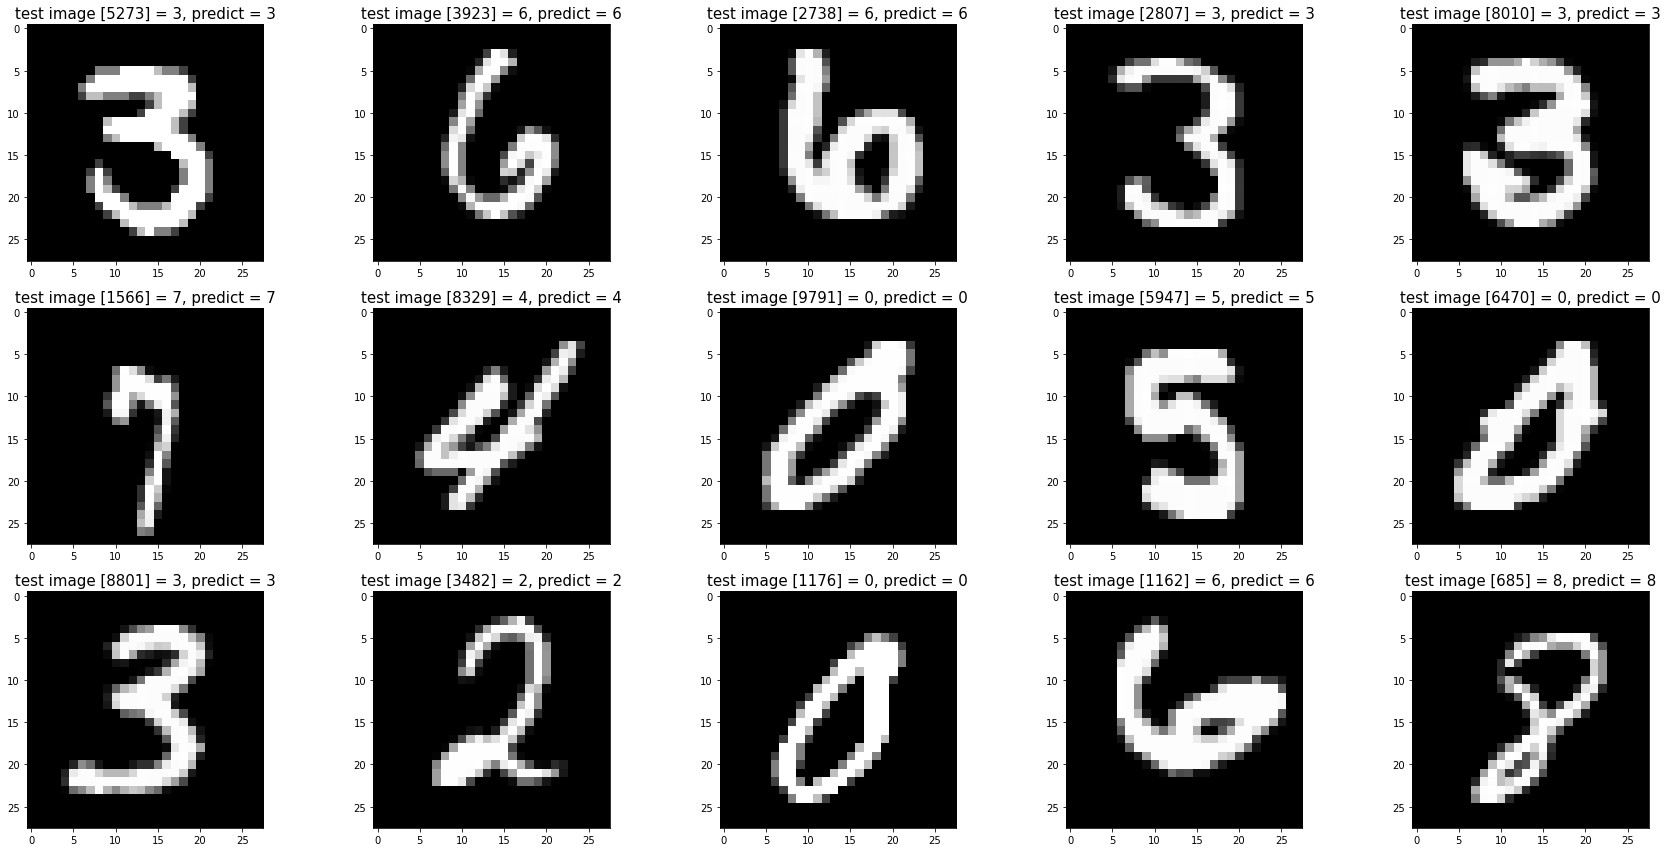

In [18]:
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
images_2_show = []
titles_2_show = []
for i in range(0, 15):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]) + ', predict = ' + str(y_test_pred_labels[r]))    

show_images(images_2_show, titles_2_show)